In [1]:
import numpy as np
import pandas as pd
import sklearn.metrics as mtr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import Callback, EarlyStopping
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Reshape, Dropout, merge, Add
from keras.layers.embeddings import Embedding
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
import warnings
import random as rn
import tensorflow as tf
from keras.models import load_model
import os
from sklearn.metrics import f1_score
from collections import Counter
import keras
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

Using TensorFlow backend.


In [2]:
PATH = '../input/oceantianchi/'

In [3]:
train = pd.read_feather(PATH + 'train.feather')
test = pd.read_feather(PATH + 'test.feather')

In [4]:
train[train.isna().T.any()]

,Unnamed: 0,渔船ID,x,y,速度,方向,time,type


In [5]:
test[test.isna().T.any()]

,渔船ID,x,y,速度,方向,time


In [6]:
train.drop('Unnamed: 0', axis = 1, inplace = True)
train.columns = ['id', 'x', 'y', 'speed', 'ori', 'time', 'type']
train.head()

,id,x,y,speed,ori,time,type
0,0,6.152038e+06,5.124873e+06,2.59,102,1110 11:58:19,拖网
1,0,6.151230e+06,5.125218e+06,2.70,113,1110 11:48:19,拖网
2,0,6.150421e+06,5.125563e+06,2.70,116,1110 11:38:19,拖网
3,0,6.149612e+06,5.125907e+06,3.29,95,1110 11:28:19,拖网
4,0,6.148803e+06,5.126252e+06,3.18,108,1110 11:18:19,拖网


In [7]:
test.columns = ['id', 'x', 'y', 'speed', 'ori', 'time']
test.head()

,id,x,y,speed,ori,time
0,7000,7.118845e+06,5.918277e+06,0.11,0,1103 11:54:32
1,7000,7.118940e+06,5.918285e+06,0.32,346,1103 11:44:32
2,7000,7.118948e+06,5.918174e+06,0.11,0,1103 11:34:43
3,7000,7.118948e+06,5.918174e+06,0.11,71,1103 11:14:30
4,7000,7.118948e+06,5.918174e+06,0.11,30,1103 11:04:46


In [8]:
train.type.unique()

array(['拖网', '围网', '刺网'], dtype=object)

In [9]:
type_dict = {'围网':0, '拖网':1, '刺网':2}
type_dict_inverse = {0:'围网', 1:'拖网', 2:'刺网'}

train.type = train.type.map(type_dict)
train

,id,x,y,speed,ori,time,type
0,0,6.152038e+06,5.124873e+06,2.59,102,1110 11:58:19,1
1,0,6.151230e+06,5.125218e+06,2.70,113,1110 11:48:19,1
2,0,6.150421e+06,5.125563e+06,2.70,116,1110 11:38:19,1
3,0,6.149612e+06,5.125907e+06,3.29,95,1110 11:28:19,1
4,0,6.148803e+06,5.126252e+06,3.18,108,1110 11:18:19,1
...,...,...,...,...,...,...,...
2699633,999,6.138413e+06,5.162715e+06,0.32,40,1031 13:09:00,1
2699634,999,6.138412e+06,5.162606e+06,0.22,275,1031 12:48:58,1
2699635,999,6.138413e+06,5.162715e+06,0.32,0,1031 12:28:01,1
2699636,999,6.138413e+06,5.162715e+06,0.32,0,1031 12:18:00,1


In [10]:
def feature_engineer(df, test=False):
    df['speed'] = df['speed']
    df['ori'] = df['ori'] / 180.0 * np.pi
    df['speed_sin'] = df['speed'] * np.sin(df['ori'])
    df['speed_cos'] = df['speed'] * np.cos(df['ori'])
    
    if test:
        df = df.groupby(['id']).agg({'x': ['std', 'min', 'max', 'mean'], 
                                     'y': ['std', 'min', 'max', 'mean'], 
                                     'speed_sin': ['std', 'min', 'max', 'mean'], 
                                     'speed_cos': ['std', 'min', 'max', 'mean'], 
                                     'speed': ['std', 'min', 'max', 'mean'], 
                                     'ori': ['std', 'min', 'max', 'mean']}).reset_index()

        df.columns = ['id', 
                      'x_std', 'x_min', 'x_max', 'x_mean',
                      'y_std', 'y_min', 'y_max', 'y_mean', 
                      'speed_sin_std', 'speed_sin_min', 'speed_sin_max', 'speed_sin_mean', 
                      'speed_cos_std', 'speed_cos_min', 'speed_cos_max', 'speed_cos_mean',
                      'speed_std', 'speed_min', 'speed_max', 'speed_mean', 
                      'ori_std', 'ori_min', 'ori_max', 'ori_mean']
        
    else:
        df = df.groupby(['id', 'type']).agg({'x': ['std', 'min', 'max', 'mean'], 
                                             'y': ['std', 'min', 'max', 'mean'], 
                                             'speed_sin': ['std', 'min', 'max', 'mean'], 
                                             'speed_cos': ['std', 'min', 'max', 'mean'],
                                             'speed': ['std', 'min', 'max', 'mean'], 
                                             'ori': ['std', 'min', 'max', 'mean']}).reset_index()
        df.columns = ['id', 'type', 
                      'x_std', 'x_min', 'x_max', 'x_mean',
                      'y_std', 'y_min', 'y_max', 'y_mean', 
                      'speed_sin_std', 'speed_sin_min', 'speed_sin_max', 'speed_sin_mean', 
                      'speed_cos_std', 'speed_cos_min', 'speed_cos_max', 'speed_cos_mean',
                      'speed_std', 'speed_min', 'speed_max', 'speed_mean', 
                      'ori_std', 'ori_min', 'ori_max', 'ori_mean']
    
    
    
    return df

In [11]:
train = feature_engineer(train)

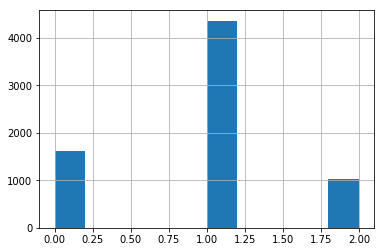

In [12]:
target = train.type
target.hist()

In [13]:
important = ['x_std', 'x_min', 'x_max', 'x_mean', 
            'y_std', 'y_min', 'y_max', 'y_mean', 
            'speed_sin_std', 'speed_sin_max', 'speed_sin_mean', 
            'speed_cos_std', 'speed_cos_max', 'speed_cos_mean',
            'speed_std', 'speed_max', 'speed_mean', 
            'ori_std', 'ori_max', 'ori_mean']

num = ['id', 
       'x_std', 'x_min', 'x_max', 'x_mean', 
       'y_std', 'y_min', 'y_max', 'y_mean', 
       'speed_sin_std', 'speed_sin_min', 'speed_sin_max', 'speed_sin_mean', 
       'speed_cos_std', 'speed_cos_min', 'speed_cos_max', 'speed_cos_mean',
       'speed_std', 'speed_min', 'speed_max', 'speed_mean', 
       'ori_std', 'ori_min', 'ori_max', 'ori_mean']

features = [i for i in num if i in important]
len(features)

20

In [14]:
scaler = StandardScaler()
train[important] = scaler.fit_transform(train[important])
train[important]

,x_std,x_min,x_max,x_mean,y_std,y_min,y_max,y_mean,speed_sin_std,speed_sin_max,speed_sin_mean,speed_cos_std,speed_cos_max,speed_cos_mean,speed_std,speed_max,speed_mean,ori_std,ori_max,ori_mean
0,-0.561751,-0.481411,-0.583659,-0.589869,-0.733104,-0.451055,-0.635067,-0.557333,-0.465947,0.575714,0.489416,-1.374942,-1.135842,-0.132880,-0.493257,-0.069170,-1.105644,-2.971593,-3.894416,-2.174746
1,-0.074971,-0.737770,-0.764905,-0.693781,0.547405,-0.774836,-0.704157,-0.702666,0.153581,-0.407276,-0.243683,0.257997,-0.695451,-0.728231,0.581405,0.092406,-0.148014,-0.397695,-0.166976,-1.178604
2,-0.766067,-0.242729,-0.469796,-0.352696,-0.774045,-0.179835,-0.392333,-0.305347,0.991019,8.387629,0.543785,-0.001446,3.580308,0.361676,1.569120,6.075185,-0.870736,0.762649,0.265191,0.120273
3,-0.034344,-3.792945,-3.742437,-3.869174,-0.202379,-2.612089,-2.649613,-2.666767,0.443121,0.488293,0.156091,-0.011480,0.645021,0.069020,0.695528,0.035555,-0.245478,0.713557,0.121135,0.077329
4,-0.521887,2.983762,2.774408,2.922148,-0.179424,3.378767,3.243342,3.374298,0.131911,0.505638,-0.144988,0.268948,0.621621,0.029078,0.664260,0.035555,-0.287669,0.690527,0.247184,0.423932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,0.954782,-0.051338,0.078406,0.048052,0.885207,-0.350640,-0.170606,-0.248711,0.442434,0.591762,1.213694,1.455428,-0.221410,-0.599728,0.964440,0.035555,0.906308,0.822867,0.265191,0.588547
6996,-0.226792,0.686989,0.667973,0.692415,-0.023549,0.763154,0.769158,0.760091,0.107118,0.186597,0.545167,0.806734,0.074428,-0.189717,-0.463305,-0.149957,0.864612,0.122281,0.229177,0.702050
6997,-0.007499,-3.792534,-3.743690,-3.865215,-0.181948,-2.611080,-2.649613,-2.669614,0.560050,0.487543,0.117786,-0.245987,0.290478,0.155278,0.637974,0.035555,-0.224255,0.579324,0.157149,0.395363
6998,-0.416964,0.436643,0.277411,0.356727,0.460642,0.412054,0.493816,0.499432,-0.274385,0.458726,0.096619,0.523549,0.579499,-0.737121,0.207946,0.004138,0.102791,0.296266,0.265191,0.393043


In [15]:
import matplotlib.pyplot as plt

def cm_plot(original_label, predict_label, pic=None):
    cm = confusion_matrix(original_label, predict_label)   # 由原标签和预测标签生成混淆矩阵
    plt.figure()
    plt.matshow(cm, cmap=plt.cm.Blues)     # 画混淆矩阵，配色风格使用cm.Blues
    plt.colorbar()    # 颜色标签
    for x in range(len(cm)):
        for y in range(len(cm)):
            plt.annotate(cm[x, y], xy=(x, y), horizontalalignment='center', verticalalignment='center')
    plt.xlabel('True label')  # 坐标轴标签
    plt.ylabel('Predicted label')  # 坐标轴标签
    plt.title('confusion matrix')
    if pic is not None:
        plt.savefig(str(pic) + '.jpg')
    plt.show()

In [16]:
def F1_score(y_true, y_pred):
    C=confusion_matrix(y_true, y_pred)
    
    TP_0 = C[0][0]
    FN_0 = C[0][1] + C[0][2]
    FP_0 = C[1][0] + C[2][0]
    TN_0 = sum(sum(C)) - TP_0 - FN_0 - FP_0
    precision_0 = TP_0/(TP_0 + FP_0)
    recall_0 = TP_0/(TP_0 + FN_0)
    F1_0 = 2 * precision_0 * recall_0/(precision_0 + recall_0)
    
    TP_1 = C[1][1]
    FN_1 = C[1][0] + C[1][2]
    FP_1 = C[0][1] + C[2][1]
    TN_1 = sum(sum(C)) - TP_1 - FN_1 - FP_1
    precision_1 = TP_1/(TP_1 + FP_1)
    recall_1 = TP_1/(TP_1 + FN_1)
    F1_1 = 2 * precision_1 * recall_1/(precision_1 + recall_1)
    
    TP_2 = C[2][2]
    FN_2 = C[2][0] + C[2][1]
    FP_2 = C[0][2] + C[1][2]
    TN_2 = sum(sum(C)) - TP_2 - FN_2 - FP_2
    precision_2 = TP_2/(TP_2 + FP_2)
    recall_2 = TP_2/(TP_2 + FN_2)
    F1_2 = 2 * precision_2 * recall_2/(precision_2 + recall_2)
    return F1_0, F1_1, F1_2

In [17]:
from keras.utils import to_categorical
target = to_categorical(target)
target

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [18]:
def NN_model():
    init = keras.initializers.glorot_uniform(seed=1)
    model = keras.models.Sequential()
    model.add(Dense(units=32, input_dim=len(important), kernel_initializer=init, activation='relu'))
    model.add(Dense(units=64, kernel_initializer=init, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units=32, kernel_initializer=init, activation='relu'))
    model.add(Dense(units=16, kernel_initializer=init, activation='relu'))
    model.add(Dense(units=8, kernel_initializer=init, activation='relu'))
    model.add(Dense(units=3, kernel_initializer=init, activation='softmax'))
    
    return model


In [19]:
class Metric(Callback):
    def __init__(self, model, callbacks, data):
        super().__init__()
        self.model = model
        self.callbacks = callbacks
        self.data = data

    def on_train_begin(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_begin(logs)

    def on_train_end(self, logs=None):
        for callback in self.callbacks:
            callback.on_train_end(logs)

    def on_epoch_end(self, batch, logs=None):
        X_train, y_train = self.data[0][0], self.data[0][1]
        y_pred3 = self.model.predict(X_train)
        y_pred = np.zeros((len(y_pred3), ))
        y_true = np.zeros((len(y_pred3), ))
        for i in range(len(y_pred3)):
            y_pred[i] = list(y_pred3[i]).index(max(y_pred3[i]))
        for i in range(len(y_pred3)):
            y_true[i] = list(y_train[i]).index(max(y_train[i]))
        trn_s = f1_score(y_true, y_pred, average='macro')
        logs['trn_score'] = trn_s
        
        X_val, y_val = self.data[1][0], self.data[1][1]
        y_pred3 = self.model.predict(X_val)
        y_pred = np.zeros((len(y_pred3), ))
        y_true = np.zeros((len(y_pred3), ))
        for i in range(len(y_pred3)):
            y_pred[i] = list(y_pred3[i]).index(max(y_pred3[i]))
        for i in range(len(y_pred3)):
            y_true[i] = list(y_val[i]).index(max(y_val[i]))
        val_s = f1_score(y_true, y_pred, average='macro')
        logs['val_score'] = val_s
        print('trn_score', trn_s, 'val_score', val_s)

        for callback in self.callbacks:
            callback.on_epoch_end(batch, logs)

In [20]:
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=2020)

In [21]:
import keras 

b_size = 2
max_epochs = 100
oof_pred = np.zeros((len(train), ))
models = []
for fold, (trn_idx, val_idx) in enumerate(kf.split(train[important], train.type)):
    print('fold:', fold)
    X_train, y_train = train[important].loc[trn_idx], target[trn_idx]
    X_val, y_val = train[important].loc[val_idx], target[val_idx]
    
    model = NN_model()
    simple_adam = keras.optimizers.Adam()
    model.compile(loss='categorical_crossentropy', optimizer=simple_adam, metrics=['accuracy'])
    es = EarlyStopping(monitor='val_score', patience=10, verbose=1, mode='max', restore_best_weights=True,)
    es.set_model(model)
    metric = Metric(model, [es], [(X_train, y_train), (X_val, y_val)])
    model.fit(X_train, y_train, batch_size=b_size, epochs=max_epochs, 
              validation_data = [X_val, y_val],
              callbacks=[metric], shuffle=True, verbose=1)
    y_pred3 = model.predict(X_val)
    y_pred = np.zeros((len(y_pred3), ))
    models.append(model)
    for i in range(len(y_pred3)):
        y_pred[i] = list(y_pred3[i]).index(max(y_pred3[i]))
        
    oof_pred[val_idx] = y_pred
    F1_0_val, F1_1_val, F1_2_val = F1_score(train.type.loc[val_idx], y_pred)
    score_ = (F1_0_val + F1_1_val + F1_2_val)/3
    print()
    print('F1_0_val is:{}, F1_1_val is:{}, F1_2_val is:{}, total score is : {}'.format(F1_0_val, F1_1_val, F1_2_val, score_))
    print()

F1_0, F1_1, F1_2 = F1_score(train.type, oof_pred)
score_ = (F1_0 + F1_1 + F1_2)/3
print()
print('F1_0_val is:{}, F1_1_val is:{}, F1_2_val is:{}, total score is : {}'.format(F1_0, F1_1, F1_2, score_))
f1_score(train.type, oof_pred, average='macro')

fold: 0
Train on 5598 samples, validate on 1402 samples
Epoch 1/100
5598/5598 [==============================] - 6s 1ms/step - loss: 0.6787 - accuracy: 0.7199 - val_loss: 0.6336 - val_accuracy: 0.7190
trn_score 0.6956237879616752 val_score 0.6492038314954588
Epoch 2/100
5598/5598 [==============================] - 6s 1ms/step - loss: 0.5951 - accuracy: 0.7510 - val_loss: 0.6014 - val_accuracy: 0.7475
trn_score 0.7058945315153456 val_score 0.6794128172071936
Epoch 3/100
5598/5598 [==============================] - 6s 1ms/step - loss: 0.5529 - accuracy: 0.7674 - val_loss: 0.5578 - val_accuracy: 0.7518
trn_score 0.6922057435352951 val_score 0.6558652348316647
Epoch 4/100
5598/5598 [==============================] - 6s 1ms/step - loss: 0.5319 - accuracy: 0.7690 - val_loss: 0.5671 - val_accuracy: 0.7461
trn_score 0.7286320355938551 val_score 0.6873080803931927
Epoch 5/100
5598/5598 [==============================] - 6s 1ms/step - loss: 0.5228 - accuracy: 0.7749 - val_loss: 0.5591 - val_accu

0.730040575615006

In [22]:
test = feature_engineer(test, test=True)

In [23]:
test[important] = scaler.fit_transform(test[important])
test[important]

,x_std,x_min,x_max,x_mean,y_std,y_min,y_max,y_mean,speed_sin_std,speed_sin_max,speed_sin_mean,speed_cos_std,speed_cos_max,speed_cos_mean,speed_std,speed_max,speed_mean,ori_std,ori_max,ori_mean
0,-0.262833,3.069990,3.035617,3.101512,-0.406656,2.393115,2.453454,2.432599,0.363191,0.469540,0.520874,0.538807,0.455983,-0.638705,1.042360,0.021187,-0.144552,0.507427,0.254471,0.379963
1,-0.404578,-0.098783,-0.211853,-0.138093,0.066743,-0.237080,-0.217537,-0.234868,0.466428,0.518821,-0.292704,1.105678,0.822715,0.113178,0.467624,0.021187,0.860456,0.077351,0.180373,0.624419
2,0.944927,1.199837,1.632259,1.530079,1.641883,0.528292,0.983135,0.785946,0.645973,0.212303,1.821421,0.553906,0.507174,2.347646,0.719707,0.021187,0.797401,0.425439,0.235947,0.820567
3,-0.129142,-0.343044,-0.397233,-0.436262,-0.430396,-0.244431,-0.349826,-0.272895,0.446298,0.575161,-0.041552,-0.108925,0.110184,0.000014,0.836987,0.021187,-0.515798,0.661055,0.254471,0.078360
4,-0.072288,0.393188,0.360064,0.311796,0.001638,0.376797,0.388380,0.466091,0.296491,0.661817,0.571083,0.306650,0.284893,-0.275893,0.868187,0.021187,-0.274008,0.544657,0.161849,0.110225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.272909,0.448762,0.813073,0.434242,-0.564160,0.631898,0.476017,0.536370,1.310504,-0.028098,-2.264725,-0.229295,0.822326,-0.305646,1.530288,0.021187,0.095520,0.388622,0.180373,0.821723
1996,-0.396299,0.525873,0.411600,0.493597,0.624527,0.386501,0.529850,0.411957,0.184931,0.668171,-0.182833,1.381210,0.783881,0.274104,0.353567,0.021187,0.969127,0.187911,0.235947,0.889243
1997,-0.736703,0.556438,0.306443,0.446030,-0.770590,0.858814,0.642283,0.758270,-1.602782,-1.452558,0.012218,-1.608907,-1.637190,0.040152,-1.760166,-1.513177,-1.272015,-2.916314,-0.060445,-2.286806
1998,-0.145311,-0.130097,-0.178028,-0.150768,1.458013,-0.457088,-0.218293,-0.273590,-0.063972,0.281910,-0.285366,0.560433,-0.433942,-1.623616,0.572493,0.021187,0.098524,0.254146,0.217422,0.245763


In [24]:
y_preds = []
for model in models:
    y_preds.append(model.predict(test[important]))
y = np.mean(y_preds, axis=0)

In [25]:
y_ = np.zeros([len(y), 3])

In [26]:
y_ = np.zeros([len(y), 1])

for i in range(len(y)):
    y_[i] = list(y[i]).index(max(y[i]))
y_, len(y)

(array([[0.],
        [1.],
        [0.],
        ...,
        [2.],
        [1.],
        [2.]]), 2000)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4c8955d390>]],
      dtype=object)

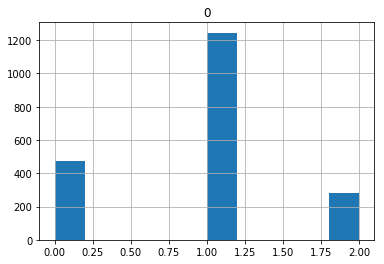

In [27]:
y_ = pd.DataFrame(y_)
y_.hist()

In [28]:
submission = pd.DataFrame()
submission['id'] = test.id
submission['type'] = test.id
submission['type'] = y_
submission.type = submission.type.map(type_dict_inverse)
submission

,id,type
0,7000,围网
1,7001,拖网
2,7002,围网
3,7003,刺网
4,7004,围网
...,...,...
1995,8995,围网
1996,8996,拖网
1997,8997,刺网
1998,8998,拖网


In [29]:
submission.to_csv('submission.csv', index=False, header=False)